In [0]:
!pip install fastai==1.0.52
from fastai.text import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import os
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
char=path/'Thesis Data'/'char-ulm'
subsets=aa/'subsets'

In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  
  return final_preds,targets

### LM

In [0]:
bs = 32
bptt = 70
vocab = " !\"#$%&'()*+,-./0123456789:;=<>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~¥§©±ঃঅআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়ািীুূৃেৈোৌ্ৎৗড়ঢ়য়০১২৩৪৫৬৭৮৯৷‘’‚“”‪™−√∝∞"

In [0]:
class NewTokenizer(BaseTokenizer):
    def tokenizer(self,t):
      return [BOS]+[i for i in t]

In [0]:
itos = [UNK, PAD, BOS, EOS, FLD, TK_REP, TK_WREP] + [i for i in vocab]

In [8]:
len(itos) ##188

188

In [0]:
vocab=Vocab(itos)
tokenizer=Tokenizer(NewTokenizer, pre_rules=[], post_rules=[])

## 6 Authors

### FineTune LM

In [0]:
bs = 128
data_lm = TextLMDataBunch.from_csv(subsets , '6train.csv', bs=bs , bptt=bptt,tokenizer=tokenizer, vocab=vocab)
data_lm.save('6train_char_lm.pkl')

In [0]:
data_lm.show_batch()

idx,text
0,্ র ে দ ে খ ি ত ে ছ ে স ে স ম ্ ব ন ্ ধ ে ত া হ া র ন ি জ ে র য দ ি চ ে ত ন া থ া ক ি ত ত ব ে স ে
1,ি ন ে ই ত া xxunk হ া ক ে এ ক ে ব া র ে শ য ্ য া শ া য় ি ন ী ক র ি য় া দ ি ল xxunk ন ী ল ক ণ ্ ঠ ম ু খ ু য ্ য ে ম শ া
2,় ে ক স প ্ ত া হ য খ ন ত া ক ে অ চ ে ত ন ক র ে ঘ ু ম প া ড ় ি য ় ে র া খ া হ ল ো ত খ ন ো এ ই
3,চ ে আ ছ ি xxunk এ ব xxunk প ্ র ত ি ম ু হ ূ র ্ ত ে আ ল ্ ল া হ র ক া ছ ে প ্ র া র ্ থ ন া ক র ছ ি য ে ন আ ম া
4,ে স ঙ ্ গ ে ন ি য় ে স ে ফ ি র ে ছ ি ল xxunk উ ৎ স ু ক ত ি র ি হ য় ত ো শ ম ি ত ে র শ র ী র ে র অ ব স ্ থ


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


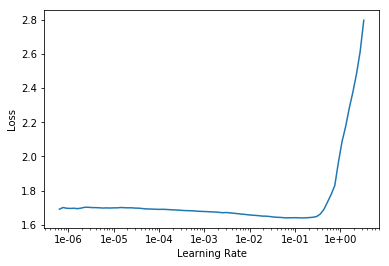

In [0]:
learn.load(char/'models'/'news_char_3less_15');
learn.lr_find()
learn.recorder.plot()

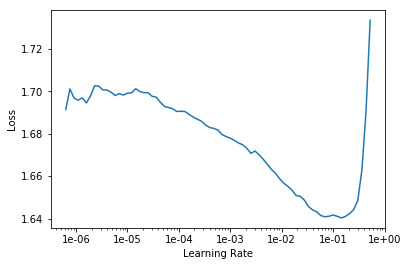

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('6train_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.579480,1.521043,0.555600,18:56
1,1.571057,1.516921,0.556475,19:01


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('6train_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.355492,1.309676,0.612025,19:44
1,1.313838,1.258636,0.625655,19:43


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('6train_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.295792,1.266039,0.624124,22:50
1,1.237550,1.205964,0.640259,22:55


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('6train_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.260877,1.246537,0.629139,23:36
1,1.265165,1.232002,0.633306,23:22
2,1.207565,1.187382,0.645579,23:17
3,1.179831,1.169500,0.650827,23:19


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('6train_char_lm_body_5');

epoch,train_loss,valid_loss,accuracy,time
0,1.236593,1.219615,0.636830,23:17
1,1.234851,1.213475,0.638404,23:15
2,1.191900,1.172733,0.649811,23:19
3,1.167190,1.156419,0.654686,23:21


In [0]:
learn.save_encoder('6train_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '6train.csv', vocab=vocab, bs=bs, tokenizer=tokenizer)
data_clas.save('6train_char_clas.pkl')

In [11]:
data_clas.show_batch()

text,target
xxbos x x b o s ক ী র ্ ত ি ত ে ত া হ া দ ে র ম ন ে গ র ্ ব ে র স ী ম া র হ ি ল ন া xxunk ব ি ন ্ ধ ্ য ব া স ি ন ী,robindronath
xxbos x x b o s ছ ি ল ন া xxunk ব ি ধ া ত া আ ম া র ম ন ে ব ো ধ ক র ি স ্ ব া ভ া ব ি ক ধ র ্ ম প ি প া স া দ ি,robindronath
xxbos x x b o s ও ক ্ র ি স ্ xxunk ম া স ে র স ম য় ত া হ া দ ি গ ক ে ধ র ্ ম গ ্ র ন ্ থ উ প হ া র প া ঠ া ই ত ে ন xxunk,robindronath
xxbos x x b o s স ন ্ ন ্ য া স ি ন ী ব ে শ ে দ া র ্ জ ি ল ি ঙ ে ক ্ য া ল ্ ক া ট া র ো ড ে র ধ া র ে ব স ি য় া ক,robindronath
xxbos x x b o s “ ই হ া ত ে আ র ত ু ম ি হ া ত দ ি ত ে প া র ি ব ে ন া xxunk ” অ ম ্ ব ি ক া চ র ণ ব ড় ো ই ত,robindronath


In [0]:
data_clas = load_data(subsets, '6train_char_clas.pkl',bs=32)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('6train_char_lm_enc')

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [14]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('6train_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,1.436896,0.444306,0.914853,18:19
1,0.503333,0.192624,0.947966,18:25


In [15]:
learn_cls.load('6train_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('6train_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.466172,0.137093,0.963103,18:56
1,0.207943,0.086481,0.980132,19:07


In [16]:
learn_cls.load('6train_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('6train_char_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.175654,0.120859,0.969726,22:12
1,0.087679,0.073611,0.978240,22:24


In [17]:
learn_cls.load('6train_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('6train_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.074935,0.056017,0.983917,25:05
1,0.051616,0.061680,0.982025,25:13
2,0.050097,0.050636,0.985809,25:08
3,0.054459,0.052694,0.985809,25:02


In [18]:
preds,targ = testing(subsets/'6test.csv')

1320
Accuracy: 
0.9878787878787879
[('MZI', 'humayun_ahmed'), ('MZI', 'humayun_ahmed'), ('MZI', 'humayun_ahmed'), ('shorotchandra', 'robindronath'), ('robindronath', 'shorotchandra'), ('humayun_ahmed', 'shomresh'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'shorotchandra'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'shomresh'), ('shomresh', 'humayun_ahmed'), ('shunil_gongopaddhay', 'shomresh'), ('shunil_gongopaddhay', 'MZI'), ('shunil_gongopaddhay', 'shomresh'), ('shunil_gongopaddhay', 'shomresh'), ('shunil_gongopaddhay', 'shomresh')]


In [19]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro') #'macro' , also == weighted cuz dataset is balanced
out

0.9878816219708947

## 8 Authors

### FineTune LM

In [0]:
bs = 128
data_lm = TextLMDataBunch.from_csv(subsets , '8train.csv', bs=bs , bptt=bptt,tokenizer=tokenizer, vocab=vocab)
data_lm.save('8train_char_lm.pkl')

In [0]:
data_lm.show_batch()

idx,text
0,"স ্ ব া ম ী ব ল ল ে ন , আ ম ি দ ে ব ত া ক ে ম া ন ি , স ে ই জ ন ্ য ে ই অ ন ্ ত র ে র ম ধ ্ য ে ন ি শ ্"
1,( ) - র ব দ ল ে এ খ ন স ি ঙ ্ গ ু ল া র দ ে ( ) ব ্ য ব হ া র ক র া র চ ল শ ু র ু হ য় ে ছ ে xxunk
2,"া য া য় ন া xxunk য ে খ ে ল ে , স ে - ও খ ে ল ো য় া ড় ন য় xxunk য ে গ া ন গ া য় , স ে ই ক ি গ া"
3,ে ন ে ফ ি র ে য া ও য় া র ক ো ন ও ম া ন ে হ য় ন া xxunk স ে দ র জ া প ে র ি য় ে ভ ে ত র ে ঢ ু ক ল !
4,ব স ্ থ া য় ফ ি র ে আ স ত ে প ে র ে ছ ে xxunk ক ী ক র ছ ? ব ি র ক ্ ত ক ো র ো ন া xxunk ক প ট গ া ম ্ ভ ী র


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


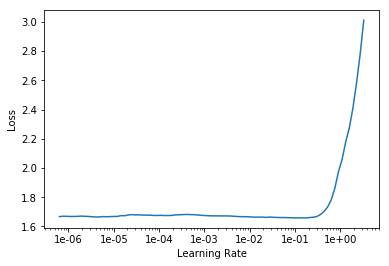

In [0]:
learn.load(char/'models'/'news_char_3less_15');
learn.lr_find()
learn.recorder.plot()

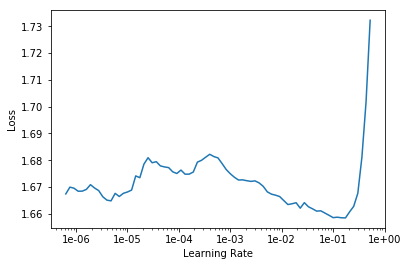

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('8train_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.584643,1.526579,0.553824,20:49
1,1.572671,1.522365,0.554951,20:52


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('8train_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.377223,1.339055,0.603489,21:38
1,1.343492,1.288688,0.616900,21:39


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('8train_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.336299,1.299368,0.614207,25:11
1,1.279843,1.237128,0.631279,25:11


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('8train_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.302312,1.278315,0.620049,27:44
1,1.302188,1.265261,0.623871,27:37
2,1.251817,1.219634,0.636405,27:37
3,1.220126,1.200378,0.641941,27:41


In [0]:
learn.load('8train_char_lm_body_3');
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('8train_char_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,1.276706,1.252979,0.627102,27:37
1,1.280062,1.248267,0.628742,27:35
2,1.243750,1.204562,0.640701,27:34
3,1.205242,1.187352,0.645779,27:36


In [0]:
learn.save_encoder('8train_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '8train.csv', vocab=vocab, bs=bs, tokenizer=tokenizer)
data_clas.save('8train_char_clas.pkl')

In [21]:
data_clas.show_batch()

text,target
xxbos x x b o s ক ী র ্ ত ি ত ে ত া হ া দ ে র ম ন ে গ র ্ ব ে র স ী ম া র হ ি ল ন া xxunk ব ি ন ্ ধ ্ য ব া স ি ন ী,robindronath
xxbos x x b o s ম া ঝ ে ম া ঝ ে স ে ই স ব প ্ র স ্ ত র ম ূ র ্ ত ি র প ূ র ্ ব ত ন খ ড় - ম া ট ি র প া দ ে খ ি,shunil_gongopaddhay
xxbos x x b o s শ ু ন ি য় া হ র ক ু ম া র প ্ র থ ম ট া ভ ী ত হ ই য় া উ ঠ ি ল ে ন ; শ শ ি ভ ূ ষ ণ ক ি ছ ু ত ে ই,robindronath
xxbos x x b o s চ া প ি য় া ধ র ি য় া ব ি দ ্ য ু দ ্ ব ে গ ে ছ ু ট ি য় া ন ি ক ট ব র ্ ত ী ক ূ প ে র ম ধ ্ য ে,robindronath
"xxbos x x b o s গ ্ র া ম ে - গ ঞ ্ জ ে ও এ খ ন ড ি স ্ ক ো চ ল ে , চ ল ে ম ি স স ু ন ্ দ র ী প ্ র ত ি য ো গ ি",toslima_nasrin


In [0]:
data_clas = load_data(subsets, '8train_char_clas.pkl',bs=32)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('8train_char_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


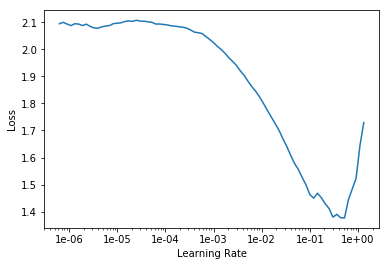

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [22]:
learn_cls.freeze()
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('8train_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.415742,0.171982,0.938707,20:08
1,0.191131,0.109328,0.963056,20:01


In [24]:
learn_cls.load('8train_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('8train_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.214239,0.099385,0.964736,21:40
1,0.103544,0.066062,0.979009,21:23


In [25]:
learn_cls.load('8train_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('8train_char_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.088566,0.062748,0.977330,25:15
1,0.050322,0.049472,0.982368,25:20


In [26]:
learn_cls.load('8train_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('8train_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.042691,0.040905,0.985726,28:09
1,0.037617,0.047656,0.985726,28:17
2,0.029253,0.044412,0.985726,28:20
3,0.025790,0.042111,0.984047,28:35


In [27]:
preds,targ = testing(subsets/'8test.csv')

1496
Accuracy: 
0.9859625668449198
[('shirshendu', 'shomresh'), ('shirshendu', 'robindronath'), ('shirshendu', 'shorotchandra'), ('shirshendu', 'shorotchandra'), ('toslima_nasrin', 'shirshendu'), ('MZI', 'humayun_ahmed'), ('shorotchandra', 'robindronath'), ('humayun_ahmed', 'toslima_nasrin'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'shorotchandra'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('shomresh', 'shunil_gongopaddhay'), ('shomresh', 'humayun_ahmed'), ('shomresh', 'toslima_nasrin'), ('shomresh', 'shunil_gongopaddhay'), ('shomresh', 'shunil_gongopaddhay'), ('shunil_gongopaddhay', 'robindronath')]


In [28]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro') #'macro' , also == weighted cuz dataset is balanced
out

0.9859286211716318

## 10 Authors

### FineTune LM

In [0]:
bs = 128
data_lm = TextLMDataBunch.from_csv(subsets , '10train.csv', bs=bs , bptt=bptt,tokenizer=tokenizer, vocab=vocab)
data_lm.save('10train_char_lm.pkl')

In [0]:
data_lm.show_batch()

idx,text
0,"র এ ক ট া ফ ু ল গ া ছ ে র ন া ম ব া xxunk দ র ল া ঠ ি ! দ ো ক া ন দ া র ট ি ব ল ল , এ খ া ন থ ে ক ে য া ও"
1,হ ি ল xxunk ল া গ ছ ে ; ব ু ঝ ত ে প া র ছ ি xxunk অ ন ্ ধ ক া র ে ব ন ব া দ া ড় ে ঘ ো র া ট া স হ জ ক া জ ন য় xxunk
2,ট ্ র া ঙ ্ ক ে ঠ া ক ু র দ া র চ ি ঠ ি প ত ্ র ছ ি ল xxunk ফ ি ত ো য ় ব া xxunk ধ া চ ি ঠ ি র ত া ড় া র ত ল া
3,ে ব ল ে দ া ও আ ম া ক ে স ঙ ্ গ ে ন ি য় ে য ে ত ে xxunk খ া ন ি ক ট া ই ত স ্ ত ু ত ক র ে প া ল দ ে ম
4,ল ে ত ো ত ো র জ য় ে ন ্ ট অ ্ য া ক া উ ন ্ ট ক র ে র া খ া উ চ ি ত xxunk জ য় ে ন ্ ট অ ্ য া ক া উ ন ্ ট


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


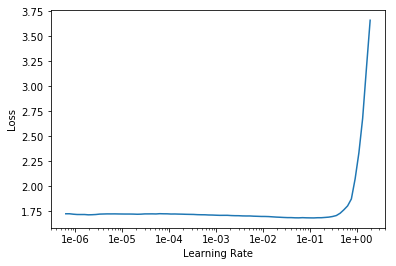

In [0]:
learn.load(char/'models'/'news_char_3less_15');
learn.lr_find()
learn.recorder.plot()

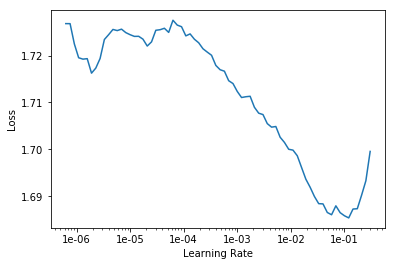

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.603913,1.548761,0.549122,23:06
1,1.594097,1.544894,0.550174,22:47


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.398780,1.345207,0.602682,23:49
1,1.352566,1.295175,0.616312,23:58


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.335339,1.306775,0.613044,27:22
1,1.273478,1.241633,0.631145,27:29


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('10train_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.310617,1.285645,0.618898,30:17
1,1.308997,1.270066,0.623486,30:14
2,1.259622,1.223897,0.636051,30:03
3,1.217422,1.203559,0.641937,30:19


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('10train_char_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,1.272681,1.262008,0.626419,30:25
1,1.282466,1.253778,0.628170,30:24
2,1.246912,1.208541,0.640370,30:22
3,1.192356,1.190017,0.645862,30:32


In [0]:
learn.save_encoder('10train_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '10train.csv', vocab=vocab, bs=bs, tokenizer=tokenizer)
data_clas.save('10train_char_clas.pkl')

In [0]:
data_clas.show_batch()

text,target
xxbos x x b o s গ xxunk ্ হ ি ত ক া র ্ য ছ ি ল ন া xxunk এ ক া ধ ি ক প ত ্ ন ী ও উ প প ত ্ ন ী স ক ল র া জ - অ,shordindu
xxbos x x b o s ক র ি ত ে ছ ে xxunk আ ম া র অ স ি - ফ ল ক অ ঙ ্ গ া র হ ই ত ে ব া হ ি র ক র ি য় া র স া য় ন - ম ি শ,shordindu
"xxbos x x b o s ক র ি ল ে ন ন া , ব া হ ি র হ ই ত ে ব দ ্ ধ া ঞ ্ জ ল ি হ ই য ় া ই ষ ্ ট দ ে ব ত া ক ে ভ ক ্ ত",shordindu
xxbos x x b o s হ া ত ে ল ই য় া র া জ ক ু ম া র ী ক ে ঘ ি র ি য় া ঘ ি র ি য় া ন ৃ ত ্ য ক র ি ত ে ছ ে এ ব xxunk,shordindu
xxbos x x b o s দ ু ই প া শ হ ই ত ে উ চ ্ চ প া ষ া ণ - প ্ র া ক া র ন ি র ্ গ ত হ ই য় া অ ন ্ ত র ্ ভ ু ক ্ ত,shordindu


In [0]:
data_clas = load_data(subsets, '10train_char_clas.pkl',bs=32)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('10train_char_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


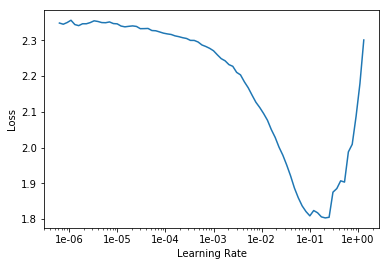

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('10train_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.502936,0.160436,0.947020,22:36
1,0.290456,0.124808,0.960265,22:30


In [0]:
learn_cls.load('10train_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('10train_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.224496,0.097840,0.969831,23:37
1,0.160911,0.073415,0.980868,23:22


In [0]:
learn_cls.load('10train_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('10train_char_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.101315,0.058229,0.981604,27:21
1,0.064108,0.056246,0.985283,27:44


In [0]:
learn_cls.load('10train_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('10train_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.058292,0.061653,0.984547,30:59
1,0.067886,0.061452,0.981604,30:50
2,0.046657,0.056042,0.981604,30:39
3,0.042963,0.050267,0.986755,31:05


In [0]:
preds,targ = testing(subsets/'10test.csv')

1700
Accuracy: 
0.98
[('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'shunil_gongopaddhay'), ('shordindu', 'robindronath'), ('shordindu', 'shorotchandra'), ('shordindu', 'shorotchandra'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shottojit_roy', 'MZI'), ('shirshendu', 'robindronath'), ('shirshendu', 'shordindu'), ('shirshendu', 'robindronath'), ('toslima_nasrin', 'shunil_gongopaddhay'), ('MZI', 'humayun_ahmed'), ('MZI', 'humayun_ahmed'), ('MZI', 'humayun_ahmed'), ('shorotchandra', 'robindronath'), ('shorotchandra', 'shunil_gongopaddhay'), ('robindronath', 'shunil_gongopaddhay'), ('robindronath', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('robindronath', 'shirshendu'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('shomresh', 'shunil_gongopaddhay'), ('shunil_gongopaddhay', 'MZI'), ('shunil_gongopaddhay', 'shomresh'), ('shunil_gongop

In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro') #'macro' , also == weighted cuz dataset is balanced
out

0.9800054945381698

## 12 Authors

### FineTune LM

In [0]:
bs = 128
data_lm = TextLMDataBunch.from_csv(subsets , '12train.csv', bs=bs , bptt=bptt,tokenizer=tokenizer, vocab=vocab)
data_lm.save('12train_char_lm.pkl')

In [0]:
data_lm.show_batch()

idx,text
0,ন ে স ত ্ য ে র এ ই প ্ র ত ্ য ক ্ ষ প ্ র ক া শ দ ে খ ত ে আ ম া র ভ া র ি চ ম ৎ ক া র ল া গ ছ ে xxunk
1,ে ম ি ত ে প ৌ xxunk ছ ে দ ি ত ে প া র ল ে অ ন ে ক ক ি ছ ু জ া ন া য া ব ে xxunk ক ্ য া প ্ ট ে ন ব xxunk ্ ক ে ন
2,ম ু ক ু ল ি ত য ে দ ি ন প া xxunk ড় ে গ ো ষ ্ ঠ ী প া ক া ব া xxunk শ ে র ল া ঠ ি হ া ত ে ক র ি য় া দ ে ব ে
3,ত া হ া র ম দ গ xxunk ্ ব ্ ব ল া ঘ ব ক র ি ত ে হ ই ব ে ; এ ব ন ে র অ ধ ী শ ্ ব র ক ে ত া হ া জ া ন া ই
4,". ব ই ল া ক ি ট া ন ট া দ ি ছ ে দ ে খ xxunk ক ম ল দ া শ গ ু প ্ ত য ে দ ি ন ম া র া গ ে ল , ত া র ক"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


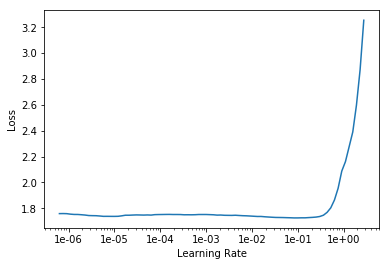

In [0]:
learn.load(char/'models'/'news_char_3less_15');
learn.lr_find()
learn.recorder.plot()

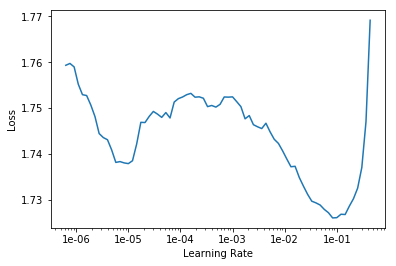

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.635156,1.595235,0.537414,18:51
1,1.649739,1.591151,0.538565,18:59


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.438243,1.392960,0.590414,19:46
1,1.386053,1.341903,0.604206,19:46


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.381732,1.347448,0.602773,22:51
1,1.319099,1.285076,0.619810,22:50


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('12train_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.334381,1.320832,0.609920,25:11
1,1.338290,1.317780,0.610912,25:09
2,1.287565,1.268038,0.624613,25:12
3,1.245148,1.248339,0.630464,25:14


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('12train_char_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,1.319310,1.302982,0.615525,25:17
1,1.324578,1.295786,0.617171,25:20
2,1.268480,1.252059,0.629230,25:13
3,1.216818,1.234498,0.634511,25:19


In [0]:
learn.save_encoder('12train_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '12train.csv', vocab=vocab, bs=bs, tokenizer=tokenizer)
data_clas.save('12train_char_clas.pkl')

In [0]:
data_clas.show_batch()

text,target
"xxbos x x b o s এ ক ন া প ি ত া ন ী আ স ি ল xxunk ন া প ি ত া ন ী স ধ ব া , খ া ট ো র া ঙ ্ গ া প ে ড় ে স া ড় ী প র",bongkim
"xxbos x x b o s অ ঙ ্ গ ে | | ” ম ৃ ণ া ল ি ন ী ক হ ি ল ে ন , “ গ ি র ি জ া য় া , এ ক ো ন অ প ্ র ে ম ি ক ে র",bongkim
"xxbos x x b o s গ ৃ হ ম ধ ্ য স ্ থ এ ক ব ্ য ক ্ ত ি ব া হ ি র ে আ স ি ল ে ন , এ ব xxunk আ স ি য় া ই ক প া ল ক ু ণ",bongkim
"xxbos x x b o s স প ্ ত ম র া ত ্ র ে ম ন ে ক র ি ল , হ ৃ দ য় ম ধ ্ য ে প দ ্ ম ফ ু ল ফ ু ট ি য় া ছ ে xxunk ত া হ া ত ে",bongkim
"xxbos x x b o s চ া ই , য ে ন ম ৃ ত ্ য ু ক া ল ে স ্ ব া ম ী র ম ু খ দ ে খ ি য় া ম র ি | ” ক ি ন ্ ত ু",bongkim


In [0]:
data_clas = load_data(subsets, '12train_char_clas.pkl',bs=32)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('12train_char_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


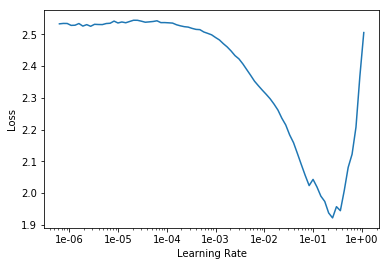

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('12train_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.817914,0.391729,0.854360,19:01
1,0.457052,0.187850,0.938776,18:51


In [0]:
learn_cls.load('12train_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('12train_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.422328,0.141211,0.944341,10:51
1,0.233633,0.095403,0.973098,11:18


In [0]:
learn_cls.load('12train_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('12train_char_cls_3')

/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:327: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


epoch,train_loss,valid_loss,accuracy,time
0,0.186106,0.112630,0.964750,12:36
1,0.114736,0.070514,0.977737,12:42


In [0]:
learn_cls.load('12train_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('12train_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.089495,0.067024,0.974954,13:50
1,0.079154,0.057700,0.977737,13:49
2,0.083994,0.062330,0.976809,13:47
3,0.060479,0.055596,0.979592,13:46


In [0]:
preds,targ = testing(subsets/'12test.csv')

1356
Accuracy: 
0.9837758112094396
[('bongkim', 'shorotchandra'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'toslima_nasrin'), ('tarashonkor', 'shorotchandra'), ('shordindu', 'bongkim'), ('shordindu', 'robindronath'), ('shordindu', 'robindronath'), ('shordindu', 'bongkim'), ('shottojit_roy', 'shordindu'), ('shirshendu', 'shomresh'), ('shirshendu', 'shordindu'), ('shirshendu', 'tarashonkor'), ('MZI', 'humayun_ahmed'), ('shorotchandra', 'bongkim'), ('shorotchandra', 'robindronath'), ('robindronath', 'shordindu'), ('robindronath', 'shunil_gongopaddhay'), ('humayun_ahmed', 'MZI'), ('shomresh', 'toslima_nasrin'), ('shunil_gongopaddhay', 'shomresh')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro') #'macro' , also == weighted cuz dataset is balanced
out

0.9837741720200613

## 14 Authors

### FineTune LM

In [0]:
bs = 128
data_lm = TextLMDataBunch.from_csv(subsets , '14train.csv', bs=bs , bptt=bptt,tokenizer=tokenizer, vocab=vocab)
data_lm.save('14train_char_lm.pkl')

In [0]:
data_lm.show_batch()

idx,text
0,ঠ ে ব স া র প র ভ ি ড় ট া প া ত ল া হ চ ্ ছ ে xxunk ক ে এ ক জ ন ত া র হ া ত ে র ও প র ে র দ ি ক ট া
1,ছ ি ল xxunk অ ফ ি স থ ে ক ে ব ে র ু ন ো র স ম য় স ে চ ল ে এ স ে ছ ি ল ফ া ই ল প ত ্ র ত ু ল ে র া খ ত ে
2,ত া ক ি ছ ু ই ন য় xxunk আ র এ ট ু ক ু প া চ ্ ছ ে ন ব ল ে ক ো ন ম ত ে চ ল ে য া চ ্ ছ ে xxunk আ দ া য ় ী ক
3,হ ব ে xxunk ক ে উ ল জ ্ জ া য় ভ য় ে ঘ র থ ে ক ে ব ে র ো ত ে প া র ছ ে ন া xxunk ত ো ম া র ব ো ন ে র
4,ে ছ ি ল xxunk স ে ই অ গ ্ ন ি র দ ী প ্ ত ি ল ক ্ ষ ্ য ক র ি য় া ন ব ক ু ম া র স ে স ্ থ ল ে আ স ি ত ে


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


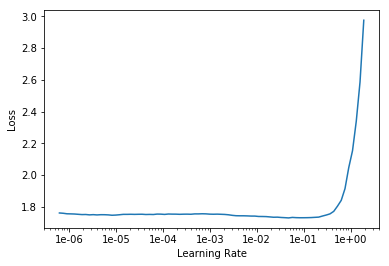

In [0]:
learn.load(char/'models'/'news_char_3less_15');
learn.lr_find()
learn.recorder.plot()

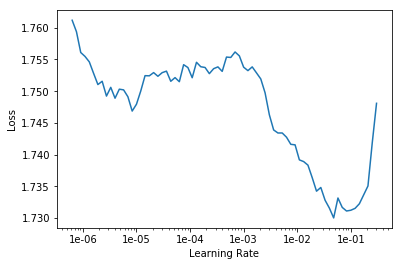

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_char_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,1.649123,1.594492,0.536595,11:20
1,1.649455,1.589668,0.538085,11:19


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_char_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,1.435215,1.391187,0.590262,11:49
1,1.388128,1.340853,0.603799,11:50


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_char_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,1.385299,1.349626,0.601543,13:31
1,1.313440,1.288924,0.617694,13:30


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('14train_char_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,1.341819,1.330962,0.607174,14:46
1,1.346650,1.313944,0.611397,14:47
2,1.293897,1.269812,0.623438,14:45
3,1.257827,1.251193,0.628886,14:47


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-2)
learn.save('14train_char_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,1.310223,1.302918,0.615060,14:44
1,1.323492,1.299476,0.615460,14:46
2,1.281457,1.255930,0.627644,14:46
3,1.229305,1.238178,0.632738,14:47


In [0]:
learn.save_encoder('14train_char_lm_enc')

### Classification (OUR AA)

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '14train.csv', vocab=vocab, bs=bs, tokenizer=tokenizer)
data_clas.save('14train_char_clas.pkl')

In [0]:
data_clas.show_batch()

text,target
"xxbos x x b o s শ ো ব ে ন ? ” শ ্ র ী শ চ ন ্ দ ্ র ব ল ি ল ে ন , “ এ স ো , আ ম র া স ব প র ি ষ ্ ক া র ক র ি",bongkim
"xxbos x x b o s গ ৃ হ ম ধ ্ য স ্ থ এ ক ব ্ য ক ্ ত ি ব া হ ি র ে আ স ি ল ে ন , এ ব xxunk আ স ি য় া ই ক প া ল ক ু ণ",bongkim
xxbos x x b o s স ে ই স ম য় ে হ ই ব ে | ” ত খ ন ন ি র ্ xxunk ম ল ঔ র ঙ ্ গ জ ে ব ক ে ত া হ া র ক প ো ত দ ে,bongkim
"xxbos x x b o s অ র ণ ্ য ম ধ ্ য ে য ে স হ চ র প া ই য় া ছ ি ল ে ন , ত া হ া র ভ ী ম ক া ন ্ ত ম য় র ূ প ; স ক",bongkim
"xxbos x x b o s স ্ থ া প ি ত হ ই ল xxunk শ ৈ ব ল ি ন ী ত া হ া প র ি ধ া ন ক র ি য় া , প ূ র ্ ব ব স ্ ত ্ র প র ি",bongkim


In [0]:
data_clas = load_data(subsets, '14train_char_clas.pkl',bs=32)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('14train_char_lm_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


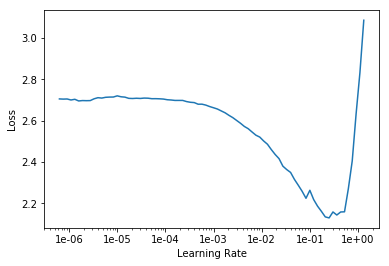

In [0]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('14train_char_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.990414,0.418464,0.870599,10:19
1,0.520574,0.293458,0.917222,10:20


In [0]:
learn_cls.load('14train_char_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('14train_char_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.439532,0.214763,0.940057,10:41
1,0.231254,0.135720,0.966698,10:54


In [0]:
learn_cls.load('14train_char_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('14train_char_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.189440,0.159846,0.957184,12:20
1,0.117692,0.101852,0.968601,12:17


In [0]:
learn_cls.load('14train_char_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('14train_char_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.079050,0.103458,0.969553,13:36
1,0.079740,0.099765,0.969553,13:32
2,0.079955,0.097069,0.972407,13:25
3,0.070009,0.098586,0.976213,13:32


In [0]:
preds,targ = testing(subsets/'14test.csv')

1316
Accuracy: 
0.9726443768996961
[('manik_bandhopaddhay', 'shunil_gongopaddhay'), ('manik_bandhopaddhay', 'tarashonkor'), ('manik_bandhopaddhay', 'tarashonkor'), ('manik_bandhopaddhay', 'shorotchandra'), ('nihar_ronjon_gupta', 'shunil_gongopaddhay'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'shorotchandra'), ('tarashonkor', 'shunil_gongopaddhay'), ('tarashonkor', 'shottojit_roy'), ('tarashonkor', 'shorotchandra'), ('shordindu', 'bongkim'), ('shordindu', 'bongkim'), ('shordindu', 'bongkim'), ('shirshendu', 'shordindu'), ('shirshendu', 'shomresh'), ('shirshendu', 'shomresh'), ('shirshendu', 'tarashonkor'), ('shirshendu', 'shomresh'), ('shirshendu', 'shomresh'), ('shirshendu', 'MZI'), ('shirshendu', 'shunil_gongopaddhay'), ('shirshendu', 'nihar_ronjon_gupta'), ('shirshendu', 'shomresh'), ('shirshendu', 'shordindu'), ('toslima_nasrin', 'shirshendu'), ('shorotchandra', 'bongkim'), ('shorotchandra', 'tarashonkor'), ('shorotchandra', 'robindronath'

In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, preds, average='macro') #'macro' , also == weighted cuz dataset is balanced
out

0.9724896865379193